In [4]:
!pip install google-play-scraper pandas numpy tensorflow scikit-learn nltk matplotlib

In [5]:
from google_play_scraper import reviews, Sort

import pandas as pd



app_id = "com.kai.kaiticketing"



result, _ = reviews(

    app_id,

    lang="id",

    country="id",

    sort=Sort.NEWEST,

    count=6000

)



data = []

for r in result:

    rating = r['score']

    if rating <= 2:

        label = "negatif"

    elif rating == 3:

        label = "netral"

    else:

        label = "positif"



    data.append({

        "review": r['content'],

        "rating": rating,

        "label": label

    })



df = pd.DataFrame(data)

df.to_csv("dataset.csv", index=False)



print("Jumlah data:", len(df))

print(df['label'].value_counts())

Jumlah data: 6000
label
positif    3322
negatif    2323
netral      355
Name: count, dtype: int64


In [6]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

stop_words = set(stopwords.words('indonesian'))

# Kata-kata ini ADA di dalam stopwords NLTK, tapi PENTING untuk sentimen MyTelkomsel

custom_keep = {
     # 1. Negasi (Sangat Wajib - agar makna tidak terbalik)
    'tidak', 'belum', 'bukan', 'jangan', 'tak', 'tiada', 'gak', 'nggak',

    # 2. Kata Hubung Pertentangan (Penting untuk kelas NETRAL)
    # Contoh: "Fitur lengkap TAPI sering logout sendiri" -> Khas bintang 3
    'tapi', 'tetapi', 'melainkan', 'padahal', 'meskipun', 'walaupun',

    # 3. Kata Keterangan Intensitas (Penguat rasa)
    'kurang', 'lebih', 'sangat', 'paling', 'terlalu', 'sedikit',

    'bisa',   # Konteks: "Gak BISA booking", "Gak BISA bayar"
    'mau',    # Konteks: "MAU pilih kursi malah mental"
    'lagi',   # Konteks: "Maintenance LAGI", "Error LAGI"
    'lama',   # Konteks: "Refund uangnya LAMA", "Loading LAMA"
    'sudah',  # Konteks: "SUDAH transfer tapi tiket tidak muncul" (Sangat Penting!)
    'baru',   # Konteks: "Update BARU malah banyak bug"
    'dapat',  # Konteks: "Susah DAPAT tiket", "Gak DAPAT flash sale"
    'kenapa', # Konteks: "KENAPA saldo terpotong?"
    'masalah',# Konteks: "Selalu ada MASALAH koneksi"
    'pakai',  # Konteks: "Bayar PAKAI LinkAja gagal", "PAKAI Qris error"
    'buat'    # Konteks: "Susah BUAT akun baru"
}



# Gabungkan dengan stopwords NLTK

stop_words = set(stopwords.words('indonesian'))

stop_words = stop_words - custom_keep



def clean_text(text):

    text = str(text).lower()

    text = re.sub(r"http\S+", "", text)

    text = re.sub(r"[^a-zA-Z\s]", " ", text)

    text = re.sub(r"\s+", " ", text).strip()

    tokens = text.split()

    tokens = [w for w in tokens if w not in stop_words]

    return " ".join(tokens)



df['review_clean'] = df['review'].apply(clean_text)

df[['review', 'review_clean', 'label']].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,review,review_clean,label
0,semakin di update semakin repot,update repot,negatif
1,BIAYA ADMIN bisa LEBIH MAHAL LAGI ga. MISAL TF...,biaya admin bisa lebih mahal lagi ga tf k biay...,negatif
2,"mantab,respon cepat,progres cepat",mantab respon cepat progres cepat,positif
3,sangat2 membantuuuuu👍👍👍👍👍👍,sangat membantuuuuu,positif
4,mantap,mantap,positif


In [7]:
from sklearn.model_selection import train_test_split

X = df['review_clean']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train:", len(X_train))
print("Test :", len(X_test))

Train: 4800
Test : 1200


In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=100, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=100, padding='post')

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dropout, Dense

cnn_model = Sequential([
    Embedding(10000, 128, input_length=100),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

cnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_cnn = cnn_model.fit(
    X_train_pad,
    y_train_enc,
    epochs=20,
    batch_size=64,
    validation_data=(X_test_pad, y_test_enc),
    callbacks=[early_stop],
    verbose=1
)

loss_cnn, acc_cnn = cnn_model.evaluate(X_test_pad, y_test_enc, verbose=0)
print("Akurasi Testing CNN:", acc_cnn)

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - accuracy: 0.6278 - loss: 0.8474 - val_accuracy: 0.8175 - val_loss: 0.5246
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - accuracy: 0.8299 - loss: 0.4854 - val_accuracy: 0.8425 - val_loss: 0.4473
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - accuracy: 0.8767 - loss: 0.3798 - val_accuracy: 0.8558 - val_loss: 0.4532
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step - accuracy: 0.8921 - loss: 0.3158 - val_accuracy: 0.8525 - val_loss: 0.4662
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - accuracy: 0.9105 - loss: 0.2605 - val_accuracy: 0.8417 - val_loss: 0.5053
Akurasi Testing CNN: 0.8424999713897705


In [11]:
from tensorflow.keras.layers import LSTM

lstm_model = Sequential([
    Embedding(10000, 128, input_length=100),
    LSTM(128),
    Dense(3, activation='softmax')
])

lstm_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_lstm = lstm_model.fit(
    X_train_pad,
    y_train_enc,
    epochs=20,
    batch_size=64,
    validation_data=(X_test_pad, y_test_enc),
    callbacks=[early_stop],
    verbose=1
)

loss_lstm, acc_lstm = lstm_model.evaluate(X_test_pad, y_test_enc, verbose=0)
print("Akurasi Testing LSTM:", acc_lstm)

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 22s 264ms/step - accuracy: 0.5400 - loss: 0.8916 - val_accuracy: 0.5533 - val_loss: 0.8648
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 269ms/step - accuracy: 0.5589 - loss: 0.8688 - val_accuracy: 0.5533 - val_loss: 0.8658
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 268ms/step - accuracy: 0.5445 - loss: 0.8716 - val_accuracy: 0.5533 - val_loss: 0.8630
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 267ms/step - accuracy: 0.5541 - loss: 0.8691 - val_accuracy: 0.5533 - val_loss: 0.8628
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 267ms/step - accuracy: 0.5548 - loss: 0.8582 - val_accuracy: 0.5533 - val_loss: 0.8647
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 247ms/step - accuracy: 0.5669 - loss: 0.8579 - val_accuracy: 0.5533 - val_loss: 0.8695
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 270ms/step - accuracy: 0.5494 - loss: 0.8652 - val_accuracy: 0.5533 - val_loss: 0.8640
Akurasi Testing LSTM: 0.5533333420753479


In [12]:
from tensorflow.keras.layers import Bidirectional

bilstm_model = Sequential([
    Embedding(10000, 128, input_length=100),
    Bidirectional(LSTM(128)),
    Dense(3, activation='softmax')
])

bilstm_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_bilstm = bilstm_model.fit(
    X_train_pad,
    y_train_enc,
    epochs=20,
    batch_size=64,
    validation_data=(X_test_pad, y_test_enc),
    callbacks=[early_stop],
    verbose=1
)

loss_bilstm, acc_bilstm = bilstm_model.evaluate(X_test_pad, y_test_enc, verbose=0)
print("Akurasi Testing BiLSTM:", acc_bilstm)

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 496ms/step - accuracy: 0.6578 - loss: 0.7475 - val_accuracy: 0.8383 - val_loss: 0.4732
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 38s 511ms/step - accuracy: 0.8375 - loss: 0.4437 - val_accuracy: 0.8492 - val_loss: 0.4402
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 36s 481ms/step - accuracy: 0.8842 - loss: 0.3374 - val_accuracy: 0.8400 - val_loss: 0.4679
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 35s 462ms/step - accuracy: 0.9002 - loss: 0.2957 - val_accuracy: 0.8358 - val_loss: 0.4926
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 49s 576ms/step - accuracy: 0.9195 - loss: 0.2246 - val_accuracy: 0.8242 - val_loss: 0.5502
Akurasi Testing BiLSTM: 0.8491666913032532


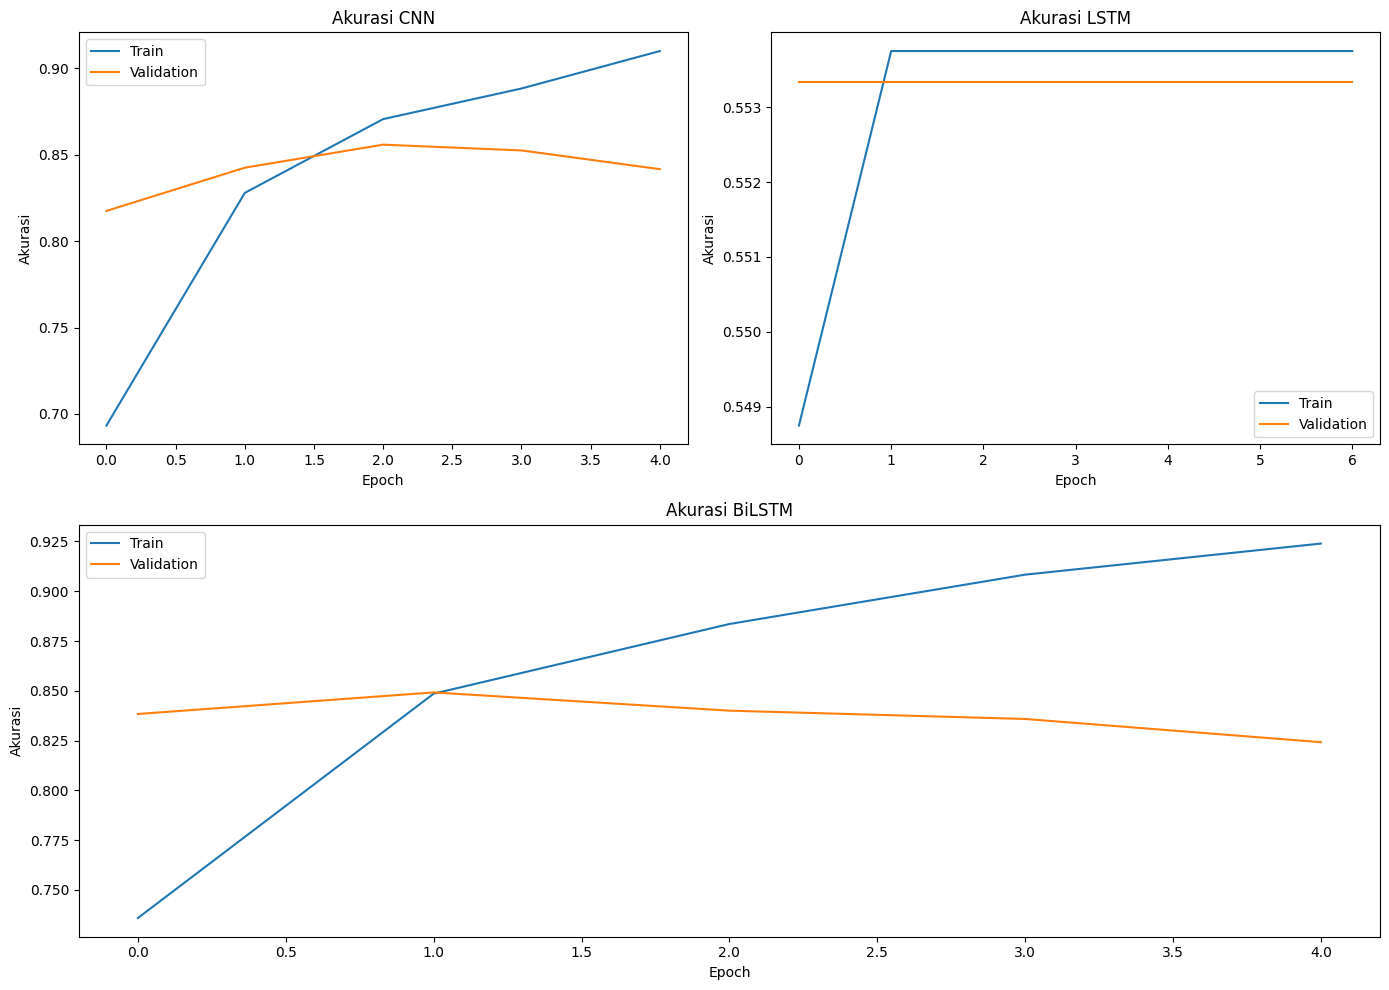

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,10))

# ===== CNN (kiri atas) =====
plt.subplot(2, 2, 1)
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('Akurasi CNN')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend(['Train', 'Validation'])

# ===== LSTM (kanan atas) =====
plt.subplot(2, 2, 2)
plt.plot(history_lstm.history['accuracy'])
plt.plot(history_lstm.history['val_accuracy'])
plt.title('Akurasi LSTM')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend(['Train', 'Validation'])

# ===== BiLSTM (bawah, lebar) =====
plt.subplot(2, 1, 2)
plt.plot(history_bilstm.history['accuracy'])
plt.plot(history_bilstm.history['val_accuracy'])
plt.title('Akurasi BiLSTM')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()

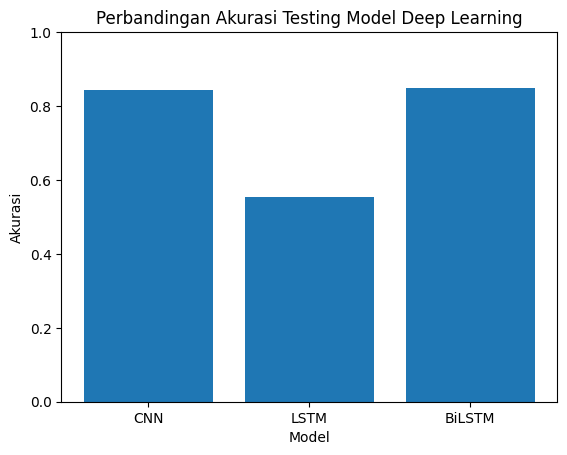

In [14]:
model_names = ['CNN', 'LSTM', 'BiLSTM']
accuracies = [acc_cnn, acc_lstm, acc_bilstm]

plt.figure()
plt.bar(model_names, accuracies)
plt.title('Perbandingan Akurasi Testing Model Deep Learning')
plt.xlabel('Model')
plt.ylabel('Akurasi')
plt.ylim(0,1)
plt.show()

In [15]:
def predict_sentiment(text):
    text = clean_text(text)
    seq = tokenizer.texts_to_sequences([text])
    pad = pad_sequences(seq, maxlen=100, padding='post')
    pred = bilstm_model.predict(pad)
    return le.inverse_transform([pred.argmax()])[0]

print("Kalimat 1:", predict_sentiment("Kenapa saya sudah bayar via transfer tapi status tiket masih menunggu pembayaran"))
print("Kalimat 2:", predict_sentiment("Sangat membantu sekali pesan tiket kereta jadi mudah tidak perlu antre di stasiun"))
print("Kalimat 3:", predict_sentiment("Aplikasi lumayan oke buat cek jadwal tapi sayang sering error pas lagi war tiket"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step
Kalimat 1: positif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Kalimat 2: positif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
Kalimat 3: negatif


In [17]:
from google.colab import files

files.download("dataset.csv")
!pip freeze > requirements.txt
files.download("requirements.txt")

print("Semua file berhasil disimpan")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Semua file berhasil disimpan
